In [9]:
%run utils.ipynb

In [2]:
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

def polynomial(x,a,b,c):
    return a*x**2+b*x+c

#e = Experiment('data/experiment--2015_03_21_17_09_56')
#e = Experiment('data/experiment--2015_04_29_16_35_42')
e = Experiment('data/experiment--2015_05_04_19_28_38')

In [3]:
eq_path = e.path + '_equalized'
eq_e = Experiment(eq_path)

In [3]:
#!rm -r $eq_path
#!cp -r $e.path $eq_path

# Uneven illumination

### computation

In [4]:
# background image
img1 = imread(e.image(0,0,4,0))

# line least variance
p1 = e.image(0,0,0,0)
img = imread(p1)

# mark line
line_variance = np.var(img, axis=0)
line = np.argmin(line_variance)
background_row = np.copy(img[line,:])
img[line-3:line+3, :] = 255

# curve fit
width = img.shape[1]
x = np.arange(width)
coefficients, covariance = curve_fit(polynomial, x, background_row)
a,b,c = coefficients
y = a*x**2+b*x+c
intensity_profile = y / y.max()

In [ ]:
# equalize eq_e experiment
def min_max(filename):
    img = imread(filename)
    return img.min(), img.max()

mm = Parallel(n_jobs=4)(delayed(min_max)(f) for f in eq_e.images)
mm = np.array(mm)
intensity_range = np.median(mm[:, 0]), np.median(mm[:, 1])

Parallel(n_jobs=4)(delayed(remove_intensity_variation)
      (f, intensity_profile, intensity_range) for f in eq_e.images)

In [31]:
equalized = imread(eq_e.image(0,0,0,0))

In [5]:
show_all_images(e.images[:2] + eq_e.images[:2])

/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/skimage/viewer/utils/core.py:11: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warnings.warn("Recommended matplotlib backend is `Agg` for full "


In [6]:
images = []
for f in e.images:
    attr = attributes(f)
    images.append((f,attr.y,attr.x))

eq_images = []
for f in eq_e.images:
    attr = attributes(f)
    eq_images.append((f,attr.y,attr.x))

#stitched = stitch(images)
eq_stitched = stitch(eq_images)

Assuming yoffset -51.0


In [8]:
imsave(eq_path + '/stitched.png', eq_stitched)

In [10]:
#thresh = filters.threshold_li(stitched)
eq_thresh = filters.threshold_li(eq_stitched)

In [11]:
selem = morphology.square(3)
ent = filters.rank.pop_bilateral(stitched, selem, s0=5, s1=5)
ent2 = filters.rank.pop_bilateral(eq_stitched, selem, s0=5, s1=5)
ent_thresh = filters.threshold_li(ent)
ent2_thresh = filters.threshold_li(ent2)

### image figures

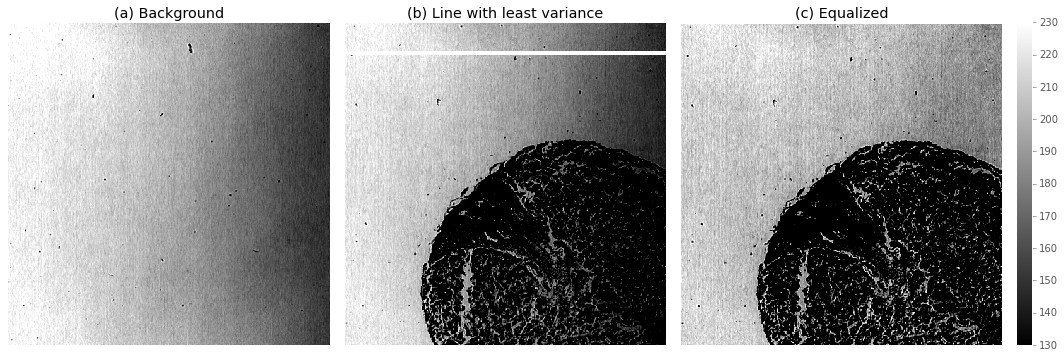

In [96]:
fig = figure(figsize=(15, 5))

gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1.086])
vmin = 130
vmax = 230

# background
ax = subplot(gs[0])
imshow_simple(img1, vmin=vmin, vmax=vmax)
#colorbar(fraction=0.046, pad=0.04)
ax.set_title('(a) Background')

# image with line
ax = subplot(gs[1])
imshow_simple(img, vmin=vmin, vmax=vmax)
#colorbar(fraction=0.046, pad=0.04)
ax.set_title('(b) Line with least variance')

# equalized image
ax = subplot(gs[2])
imshow_simple(equalized.astype(np.uint8), vmin=vmin, vmax=vmax)
colorbar(fraction=0.046, pad=0.04)
plt.title('(c) Equalized')
plt.tight_layout()

savefig('figures/uneven_illumination_images.png')

### intensitiy plots

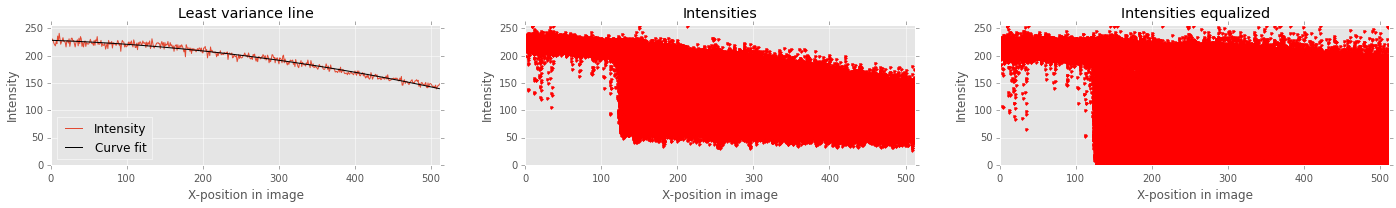

In [99]:
fig = figure(figsize=(20, 3.5))

# least variance line
subplot(131)
plot(background_row, label='Intensity')
plot(y, 'k', label='Curve fit')#, linewidth=2)
legend(loc='best')
xlabel('X-position in image')
ylabel('Intensity')
xlim(0,width)
ylim(0,256)
plt.title('Least variance line', y=1.02)

# intensities
subplot(132)
for img_line in imread(p1):
    plot(img_line, 'r.')
xlim(0,width)
ylim(0,256)
xlabel('X-position in image')
ylabel('Intensity')
plt.title('Intensities', y=1.02)

# intensities equalized
subplot(133)
for img_line in equalized:
    plot(img_line, 'r.')
xlim(0,width)
ylim(0,256)
xlabel('X-position in image')
ylabel('Intensity')
plt.title('Intensities equalized', y=1.02)
plt.tight_layout()

savefig('figures/uneven_illumination_intensities.png')

### improvement global threshold

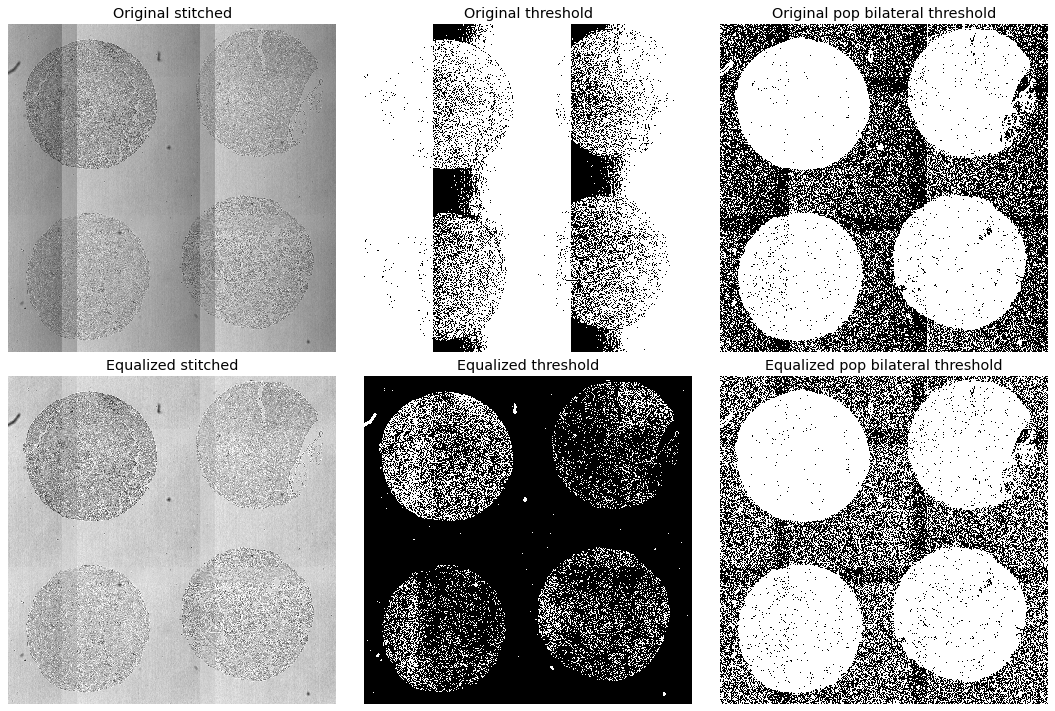

In [74]:
figure(figsize=(15,10))

mask = np.index_exp[1200:2300, 1200:2300]
subplot(231)
imshow_simple(stitched[mask])
plt.title('Original stitched')

subplot(234)
imshow_simple(eq_stitched[mask])
plt.title('Equalized stitched')


subplot(232)
imshow_simple(stitched[mask] <= thresh)
plt.title('Original threshold')


subplot(235)
imshow_simple(eq_stitched[mask] <= thresh2)
plt.title('Equalized threshold')

subplot(233)
imshow_simple(ent[mask] <= ent_thresh)
plt.title('Original pop bilateral threshold')

subplot(236)
imshow_simple(ent2[mask] <= ent2_thresh)
plt.title('Equalized pop bilateral threshold')

savefig('figures/thresholding.png')

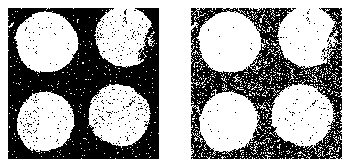

In [426]:
# comparison threshold after pop_bilateral
subplot(121)
imshow_simple(ent[mask] < ent_thresh)
subplot(122)
imshow_simple(ent2[mask] < ent2_thresh)

# Stitching

In [101]:
eq_e.stitch();

In [41]:
imagej_stitch = imread(eq_e.stitched[0])

In [48]:
imagej_scale = imagej_stitch.shape[0] / imagej_stitch.shape[1]
eq_scale = eq_stitched.shape[0] / eq_stitched.shape[1]

eq_ratio = imagej_scale / eq_scale

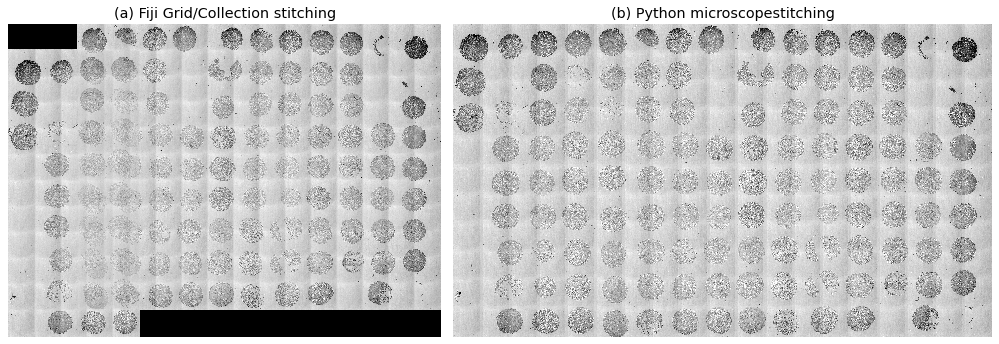

In [100]:
figure(figsize=(14,5))


gs = gridspec.GridSpec(1, 2, width_ratios=[1,eq_ratio])

subplot(gs[0])
imgplot = imshow_simple(imagej_stitch)
plt.title('(a) Fiji Grid/Collection stitching')
#no_ticks(imgplot.axes)

subplot(gs[1])
imgplot = imshow_simple(eq_stitched)
plt.title('(b) Python microscopestitching')
#no_ticks(imgplot.axes)

savefig('figures/stitching_comparison.png')

# Segmentation

In [6]:
eq_stitched = imread(eq_e.stitched[0])

In [7]:
selem = morphology.square(9)
eq_pop = filters.rank.pop_bilateral(eq_stitched, selem)
eq_pop_mean = filters.rank.mean(eq_pop, selem)

In [8]:
thresh_eq = filters.threshold_otsu(eq_stitched)
thresh_eq_pop = filters.threshold_otsu(eq_pop)
thresh_eq_pop_mean = filters.threshold_otsu(eq_pop_mean)

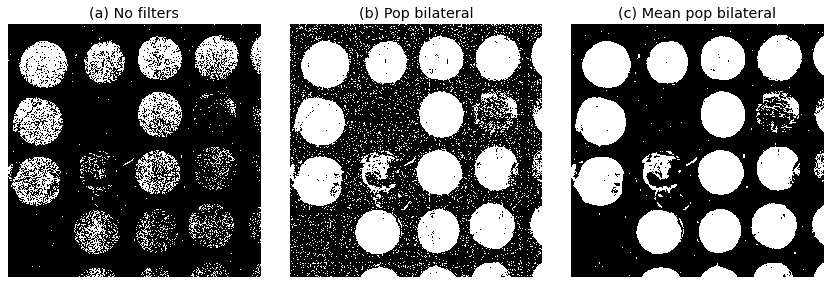

In [55]:
figure(figsize=(12,4))
mask = np.index_exp[0:2500, 0:2500]

subplot(131)
imshow_simple(eq_stitched[mask] < thresh_eq)
plt.title('(a) No filters')

subplot(132)
imshow_simple(eq_pop[mask] < thresh_eq_pop)
plt.title('(b) Pop bilateral')

subplot(133)
imshow_simple(eq_pop_mean[mask] < thresh_eq_pop_mean)
plt.title('(c) Mean pop bilateral')

plt.tight_layout()
savefig('figures/segmentation.png')

In [100]:
eq_segmented = ndimage.binary_erosion(eq_pop_mean < thresh_eq_pop_mean, selem)

In [101]:
from skimage.measure import label, regionprops

labels = label(eq_segmented, background=0) # background=0: exclude background
regions = regionprops(labels)           # measure region properties
regions.sort(key=lambda r: -r.area)     # sort by area size, largest first

max_regions = 126
if len(regions) > max_regions:
    regions = regions[:max_regions]     # only keep max_regions

for r in regions:
    r.y, r.x, r.y_end, r.x_end = r.bbox # for convenience

for direction in 'yx':                  # same algorithm for row and columns
    regions.sort(key=lambda r: getattr(r, direction))

    previous = regions[0]
    for region in regions:              # calc distance to previous region
        dx = getattr(region, direction) - getattr(previous, direction)
        setattr(region, 'd' + direction, dx)
        previous = region

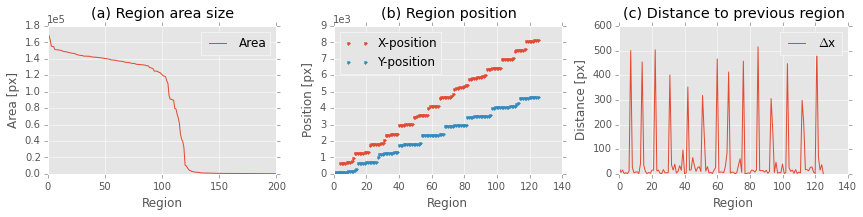

In [102]:
figure(figsize=(12,3))

subplot(131)
plot(eq_region_areas, label='Area')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
legend()
xlabel('Region')
ylabel('Area [px]')
plt.title('(a) Region area size', y=1.02)

subplot(132)
plot(sorted([r.x for r in regions]), '.', label='X-position')
plot(sorted([r.y for r in regions]), '.', label='Y-position')
legend(loc='best')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
xlabel('Region')
ylabel('Position [px]')
plt.title('(b) Region position', y=1.02)

subplot(133)
regions.sort(key=lambda r: -r.x)
plot([r.dx for r in regions], label='$\Delta$x')
legend()
xlabel('Region')
ylabel('Distance [px]')
plt.title('(c) Distance to previous region', y=1.02)
plt.tight_layout()

savefig('figures/regions_area_and_position.png')